In [1]:
# 3.2a runs percentiles for 150pc mmap, but dont need this anymore for this notebook.

In [2]:
import numpy as np
import astropy
import astropy.io.fits as pyfits
from astropy.table import Table, join, unique
from astropy.io import ascii
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.wcs import WCS
#! pip install aplpy
import aplpy

import os, sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
#sys.path.append('/Users/nessmayker/Desktop/PythonFunctions')

SNe_Gal_File = '../Data/3.SNe+GalData.csv'
database = Table.read(SNe_Gal_File, format='csv') 


In [3]:

gal_groups = database.group_by('galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

print(gals)
# print(indices)
# print(gal_groups["SN_name"][4])

images, errFiles, name, types, ras, decs = [],[],[],[],[],[]
for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["ImageFile150"][indices[i]])
    errFiles.append(gal_groups["ErrFile150"][indices[i]])
    SNnames.append(gal_groups["SN_name"][indices[i]])
    SNtypes.append(gal_groups["SN_type"][indices[i]])
    SNras.append(gal_groups["SN_ra"][indices[i]])
    SNdecs.append(gal_groups["SN_dec"][indices[i]])
    j = 1
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["SN_name"][indices[i]+j])
        SNtypes.append(gal_groups["SN_type"][indices[i]+j])
        SNras.append(gal_groups["SN_ra"][indices[i]+j])
        SNdecs.append(gal_groups["SN_dec"][indices[i]+j])
        j += 1
    name.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)    
  

 galaxy 
--------
circinus
 ngc0253
 ngc0628
 ngc1068
 ngc1087
 ngc1097
 ngc1365
 ngc1433
 ngc1511
 ngc1559
     ...
 ngc4424
 ngc4457
ngc4496a
 ngc4536
 ngc4579
 ngc4945
 ngc5128
 ngc5236
 ngc5530
 ngc6744
 ngc7793
Length = 31 rows


In [4]:

def getFileName(galaxy, typeMap, res, telOrient):

    if typeMap == "int":
        fileName = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/"  + galaxy + "/" + galaxy + "_" + str(telOrient) + "_co21" + res +  "_broad_mom0.fits"
    else:
        fileName = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/"  + galaxy + "/" + galaxy + "_" + str(telOrient) + "_co21" + res +  "_broad_emom0.fits"

    return(fileName)

# for i in range(len(database)):
#     print(database['galaxy'][i], database['telOrient'][i])

In [5]:
galaxyData = unique(database,'galaxy')

telOri, gals = [],[]

for i in range(len(galaxyData)):
    gals.append(str(galaxyData['galaxy'][i]))
    telOri.append(str(galaxyData['telOrient'][i]))


In [6]:
# set up plots, wcs information, and make sigma maps for contours.
import matplotlib.pyplot as plt
plots, sigma, wcss, hdus, beamsizes, plotAspect, ppb, corner = [],[],[],[],[],[],[],[]

for i in range(len(gals)):
        
    if os.path.isfile(images[i]):
        img = images[i]
        err = errFiles[i]

    elif os.path.isfile(getFileName(gals[i], "int", "_500pc", telOri[i])):
        img = getFileName(gals[i], "int", "_500pc", telOri[i])
        err = getFileName(gals[i], "err", "_500pc", telOri[i])
        print(img)
    
    else:
        img = getFileName(gals[i], "int", "_750pc", telOri[i])
        err = getFileName(gals[i], "err", "_750pc", telOri[i])
        print(img)
            
    co_hdu = pyfits.open(img)
    hdus.append(co_hdu)
    
    beamMaj = co_hdu[0].header['BMAJ']
    beamMin = co_hdu[0].header['BMIN']
    if(beamMaj==beamMin):
        beamsizes.append(beamMaj)
    else:
        beamsizes.append(0.0)
        
    co_map = co_hdu[0].data
    plots.append(co_map)
    err_hdu = pyfits.open(err)
    err_map = err_hdu[0].data
    sig_map = co_map / err_map
    sigma.append(sig_map)
    w = WCS(co_hdu[0].header, naxis=2)
    wcss.append(w)
    x = co_map.shape[0]
    y = co_map.shape[1]
    naxis    = w._naxis # size of image naxis[0] = x and [1] = y
    grid     = np.indices((naxis[1],naxis[0]))
#     ra, dec  = w.wcs_pix2world(grid[1],grid[0],0)  
    aspect = float(y)/float(x)
#     galDeltaRa = np.max(ra) - np.min(ra)
#     galDeltaDec =  np.max(dec) - np.min(dec)
#     beamAreaRa = beamMaj/galDeltaRa
#     beamAreaDec = beamMaj/galDeltaDec
#     beamWidths.append(beamAreaRa * x)
#     beamHeights.append(beamAreaDec * y)
#     beamCircle.append(np.sqrt(beamAreaRa * x * beamAreaDec * y))
    cdelt = co_hdu[0].header['CDELT1']
    ppb.append(beamMaj/np.abs(cdelt))
    plotAspect.append(aspect)
    corner.append(x/15.0)

print(len(plots))

/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_750pc_broad_mom0.fits
/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1672/ngc1672_12m+7m+tp_co21_500pc_broad_mom0.fits
/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc4579/ngc4579_12m+7m+tp_co21_500pc_broad_mom0.fits
31


In [7]:
legendLabels = []

for i in range(len(name)):
    legendlabel = []
    if len(name[i]) > 1:
        for k in range(len(name[i])):
            if types[i][k] == 'unclassified':
                label = name[i][k] + ' '  + types[i][k]
            else:
                label = name[i][k] + ' Type '  + types[i][k]
            legendlabel.append(label)
    else:
        if types[i][0] == 'unclassified':
            legendlabel.append(name[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(name[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)
print(legendLabels)

print(beamsizes)

[['SN1996cr Type II'], ['SN1940E Type I'], ['SN2013ej Type II'], ['SN2018ivc Type II'], ['SN1995V Type II'], ['SN1999eu Type II', 'SN1992bd Type II'], ['SN2001du Type II', 'SN1983V Type Ic', 'SN2012fr Type Ia'], ['SN1985P Type II'], ['SN1935C unclassified'], ['SN1984J Type II', 'SN1986L Type II', 'SN2005df Type Ia', 'SN2009ib Type II'], ['ASASSN-14ha Type II', 'SN2010el Type Ia'], ['SN1999em Type II'], ['SN2017gax Type Ib/c'], ['SN1993Z Type Ia'], ['SN2008eh unclassified', 'SN2003jg Type Ic'], ['SN2012A Type II'], ['SN1989B Type Ia', 'SN2016cok Type II', 'SN2009hd Type II', 'SN1973R Type II'], ['SN1967H Type II', 'SN1972Q Type II', 'SN1986I Type II', 'SN2014L Type Ic'], ['SN1961I Type II', 'SN1926A Type II', 'SN1999gn Type II', 'SN2006ov Type II', 'SN2020jfo Type II', 'SN1964F Type II', 'SN2014dt Type Ia'], ['SN1959E Type I', 'SN2006X Type Ia', 'SN2020oi Type Ic', 'SN2019ehk Type Ib', 'SN1901B Type I', 'SN1979C Type II'], ['SN2012cg Type Ia'], ['SN2020nvb Type Ia'], ['SN1988M Type II',

<ipython-input-8-0ad61d0e2b06>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  current_cmap.set_bad("black")
<ipython-input-8-0ad61d0e2b06>:19: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)
<ipython-input-8-0ad61d0e2b06>:19: RuntimeWarning: invalid value encountered in log10
  logplot = np.log10(plot)


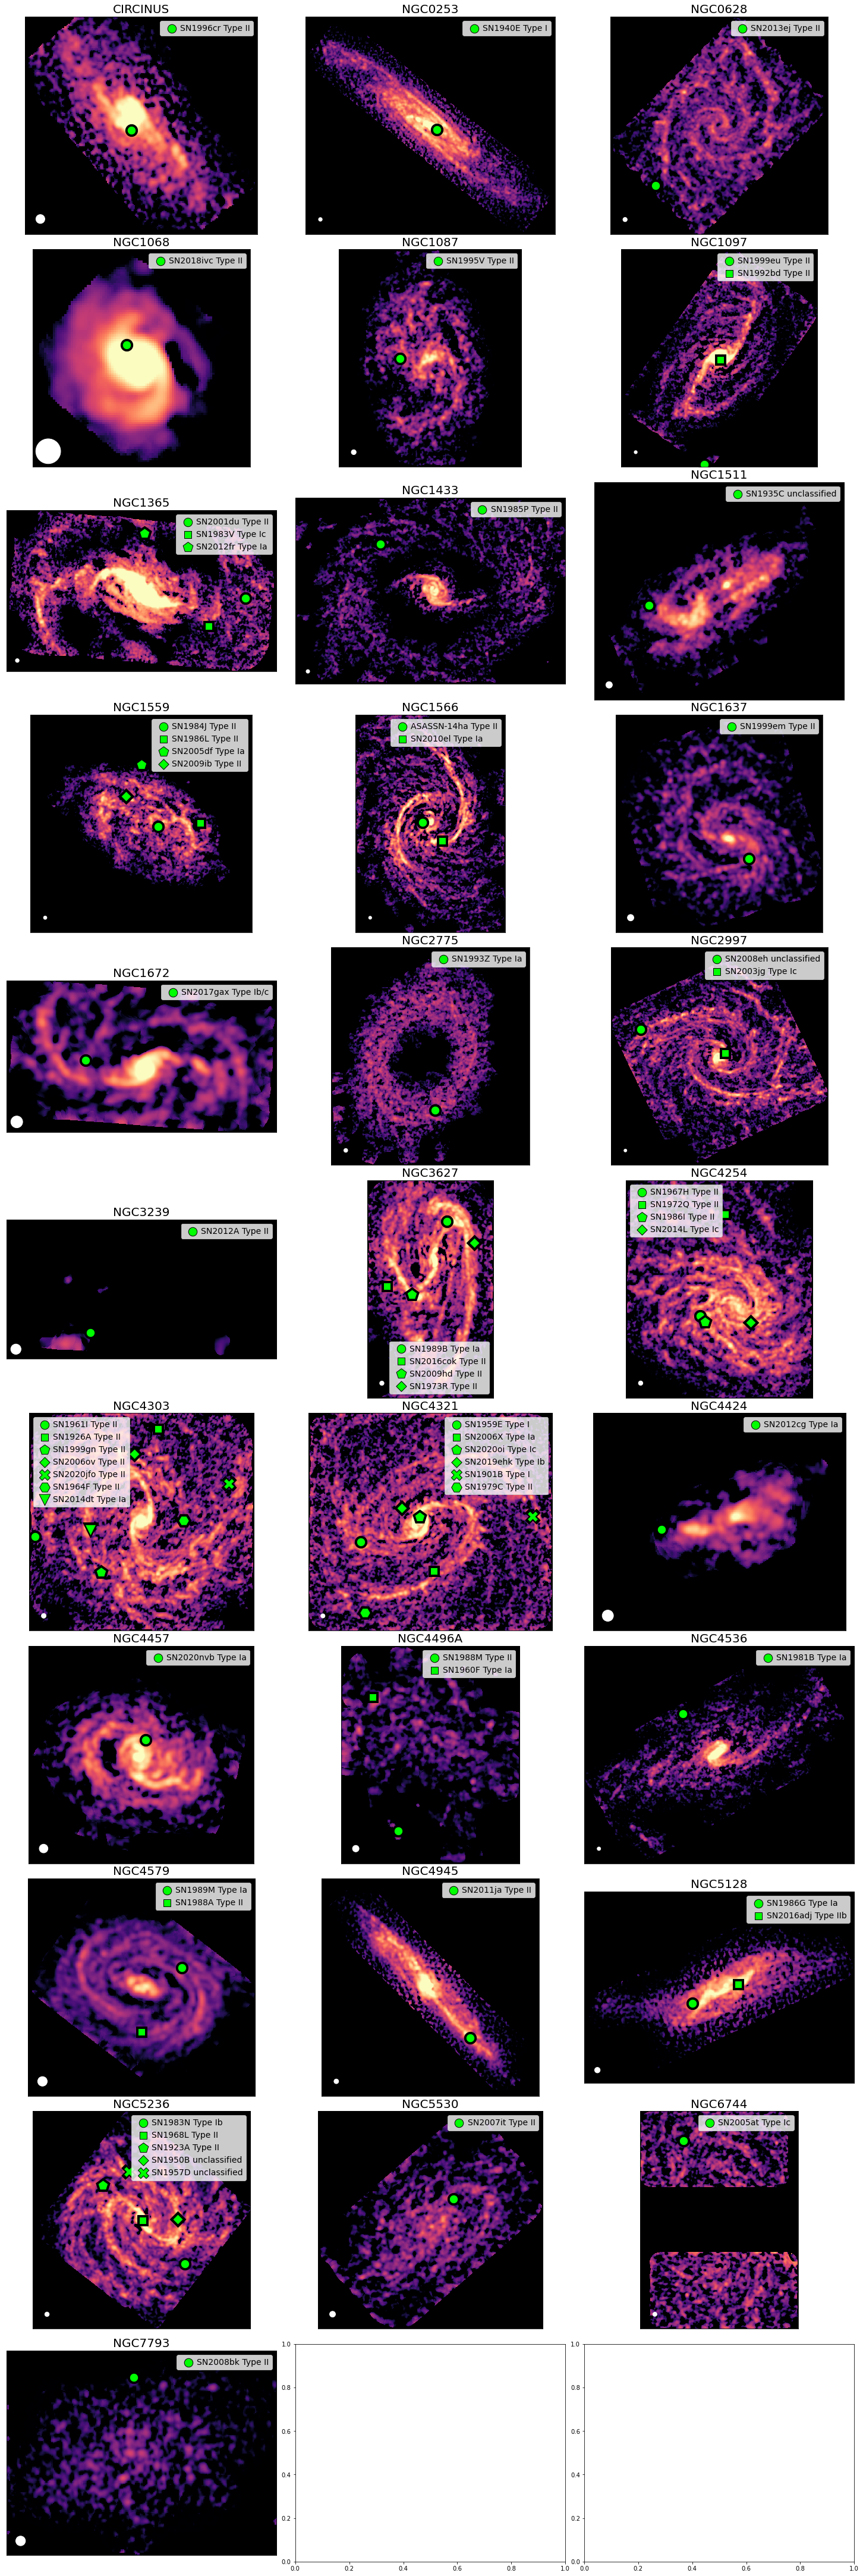

In [8]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for plot in plots:
    draw_circle = plt.Circle((corner[m], corner[m]),ppb[m], fill = True, color = 'white')

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", vmin = -0.5, vmax = 2.0, zorder = 0)
    axs[i][j].set_title(gals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].add_patch(draw_circle)
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerEdges[n], zorder=2)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], edgecolor="black", label = legendLabels[m][n], zorder = 2)
    #axs[i][j].contour(sigma[m], [3], colors = ["white"], linestyles = ("-"), zorder = 1)
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInGalaxies.png", dpi=300)
   

print()

In [9]:
# percentile_data

In [10]:
SNe_Gal_150_File = '../Data/3.SNe+GalData150.csv'
percentile_data = Table.read(SNe_Gal_150_File, format = "csv")


per_groups = percentile_data.group_by('galaxy')
gals = per_groups.groups.keys
indices = per_groups.groups.indices
indices = indices.tolist()
indices.append(0)

percentiles, types = [],[]
for i in range(len(indices)-2):
    SNpercentiles, SNtypes = [],[]
    SNpercentiles.append(per_groups["SN_percentile"][indices[i]])
    SNtypes.append(per_groups["SN_type"][indices[i]])
    j = 1
    
    while(indices[i] + j < indices[i+1]):
        SNpercentiles.append(per_groups["SN_percentile"][indices[i]+j])
        SNtypes.append(per_groups["SN_type"][indices[i]+j])
        j += 1
    percentiles.append(SNpercentiles)
    types.append(SNtypes)
    
per, typ = [],[]

for i in range(len(percentiles)):
    for j in range(len(percentiles[i])):
        per.append(percentiles[i][j])
        typ.append(types[i][j])

print(per)
print(typ)

['0.98', '0.99', 'non-detection', '0.9', '0.99', '0.05', '0.24', 'non-detection', 'non-detection', 'non-detection', 'non-detection', '0.83', 'non-detection', '0.05', '0.29', '0.98', '0.83', '0.76', 'non-detection', '1.0', '0.92', '0.7', '0.68', '0.89', '0.99', '0.18', '0.81', '0.1', '0.72', '0.98', 'non-detection', 'non-detection', 'non-detection', '0.41', 'non-detection', 'non-detection', 'non-detection', '0.56', '0.91', 'non-detection', 'non-detection', 'non-detection', '0.92', 'non-detection', '0.73', 'non-detection', '0.1', 'non-detection', '0.93', '0.65', '0.95', '0.37', '0.99', '0.96', '1.0', '0.2', 'non-detection', '0.75', 'non-detection']
['II', 'I', 'II', 'II', 'II', 'II', 'Ic', 'II', 'Ia', 'II', 'unclassified', 'II', 'II', 'Ia', 'II', 'II', 'Ia', 'II', 'Ia', 'Ic', 'unclassified', 'II', 'II', 'Ia', 'II', 'II', 'II', 'II', 'II', 'Ic', 'II', 'II', 'II', 'II', 'II', 'Ia', 'II', 'I', 'I', 'II', 'Ia', 'Ib', 'Ic', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'II', 'Ia', 'IIb', 'II', 'unclassified'

In [11]:
tiles = []

for i in range(len(per)):
    if per[i] == "non-detection":
        tiles.append(0.0)
    else:
        tiles.append(per[i])

Ias, IIs, SEs, UnC, IIn, allTiles = [],[],[],[],[],[]     
for i in range(len(typ)):
    if typ[i] == "I" or typ[i] == "unclassified":
        UnC.append(float(tiles[i]))
        allTiles.append(float(tiles[i]))
    elif typ[i] == "Ia":
        Ias.append(float(tiles[i]))
        allTiles.append(float(tiles[i]))
    elif typ[i] == "II":
        IIs.append(float(tiles[i]))
        allTiles.append(float(tiles[i]))
    elif typ[i] == "Ib" or typ[i] == "Ic" or typ[i] == "IIb": 
        SEs.append(float(tiles[i]))
        allTiles.append(float(tiles[i]))
    else:
        IIn.append(float(tiles[i]))
        



In [12]:
Ias = np.sort(Ias)
IIs = np.sort(IIs)
SEs = np.sort(SEs)
UnC = np.sort(UnC)
Til = np.sort(allTiles)

print(len(per))
print(len(Ias), len(IIs), len(SEs), len(UnC))
for i in range(len(per)):
    print(per[i], typ[i])


59
12 32 8 7
0.98 II
0.99 I
non-detection II
0.9 II
0.99 II
0.05 II
0.24 Ic
non-detection II
non-detection Ia
non-detection II
non-detection unclassified
0.83 II
non-detection II
0.05 Ia
0.29 II
0.98 II
0.83 Ia
0.76 II
non-detection Ia
1.0 Ic
0.92 unclassified
0.7 II
0.68 II
0.89 Ia
0.99 II
0.18 II
0.81 II
0.1 II
0.72 II
0.98 Ic
non-detection II
non-detection II
non-detection II
0.41 II
non-detection II
non-detection Ia
non-detection II
0.56 I
0.91 I
non-detection II
non-detection Ia
non-detection Ib
0.92 Ic
non-detection Ia
0.73 Ia
non-detection Ia
0.1 II
non-detection Ia
0.93 II
0.65 Ia
0.95 IIb
0.37 II
0.99 unclassified
0.96 unclassified
1.0 II
0.2 Ib
non-detection II
0.75 Ic
non-detection II


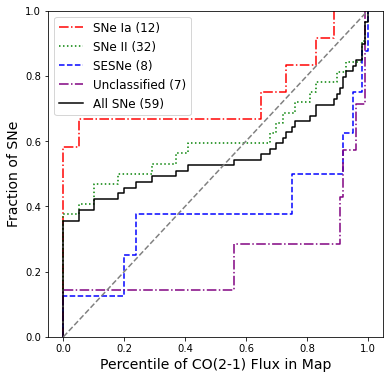

In [18]:
fig = plt.figure(figsize=(6,6))

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
yTil = np.linspace(0,1,len(Til))

sns.ecdfplot(data=Ias, color="red", label = "SNe Ia (12)", ls = "dashdot")
sns.ecdfplot(data=IIs, color="green", label = "SNe II (32)", ls = ":")
sns.ecdfplot(data=SEs, color="blue", label = "SESNe (8)", ls = "dashed")
sns.ecdfplot(data=UnC, color="purple", label = "Unclassified (7)", ls = "dashdot")
sns.ecdfplot(data=Til, color="black", label = "All SNe (59)", ls = "-")
#plt.plot(Til,yTil, color="black", label = "All SNe")
plt.plot(x,y,ls="--", color = 'grey')
plt.xlabel("Percentile of CO(2-1) Flux in Map", fontsize = 14)
plt.legend(loc="upper left", fontsize = 12)
plt.ylabel("Fraction of SNe", fontsize = 14)
fig.savefig("../Figures/CDFAllTypes.png", dpi = 300)
plt.show()
plt.close()
# print("Ia", Ias)
# print("II", IIs)
# print("SESN", SEs)
# print("Unclassified",UnC)
# print("All", Til)

In [ ]:
print(UnC)

In [ ]:
plt.close('all')